In [4]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!unzip '/content/drive/My Drive/cancer.zip' -d '/content/sample_data/mel'#unzipping dataset

Archive:  /content/drive/My Drive/cancer.zip
   creating: /content/sample_data/mel/finding/
   creating: /content/sample_data/mel/finding/test/
   creating: /content/sample_data/mel/finding/test/Melanoma/
  inflating: /content/sample_data/mel/finding/test/Melanoma/1.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1003.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1005.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1007.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1009.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1012.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1019.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1022.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1026.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1027.jpg  
  inflating: /content/sample_data/mel/finding/test/Melanoma/1037.jpg  
  inflating: /con

In [0]:
#importing the needed libraries
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers

In [0]:
#loading the folder path
nmel_train = '/content/sample_data/mel/finding/train/Not melanoma'
m_train = '/content/sample_data/mel/finding/train/Melanoma'

nmel_test = '/content/sample_data/mel/finding/test/Not melanoma'
m_test = '/content/sample_data/mel/finding/test/Melanoma'

In [0]:
#converting the images into numpy arrays
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Loading in train pics
nmel = [read(os.path.join(nmel_train, filename)) for filename in os.listdir(nmel_train)]
x_nmel = np.array(nmel, dtype='uint8')
mel = [read(os.path.join(m_train, filename)) for filename in os.listdir(m_train)]
x_mel = np.array(mel, dtype='uint8')

# Loading in test pics
nmel = [read(os.path.join(nmel_test, filename)) for filename in os.listdir(nmel_test)]
x_nmel_test = np.array(nmel, dtype='uint8')
mel = [read(os.path.join(m_test, filename)) for filename in os.listdir(m_test)]
x_mel_test = np.array(mel, dtype='uint8')

In [0]:
#label creation
y_nmel = np.zeros(x_nmel.shape[0])
y_mel = np.ones(x_mel.shape[0])#creating labels for non melanoma and melanoma in train set

y_nmel_test = np.zeros(x_nmel_test.shape[0])
y_mel_test = np.ones(x_mel_test.shape[0])#creating labels for test set


# Merge data 
x_train = np.concatenate((x_nmel, x_mel), axis = 0)#concatinating malig at bottom
y_train = np.concatenate((y_nmel, y_mel), axis = 0)

x_test = np.concatenate((x_nmel_test, x_mel_test), axis = 0)
y_test = np.concatenate((y_nmel_test, y_mel_test), axis = 0)

In [0]:
#shuffling of train and test set
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]#shuffling train set

s = np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test = x_test[s]
y_test = y_test[s]

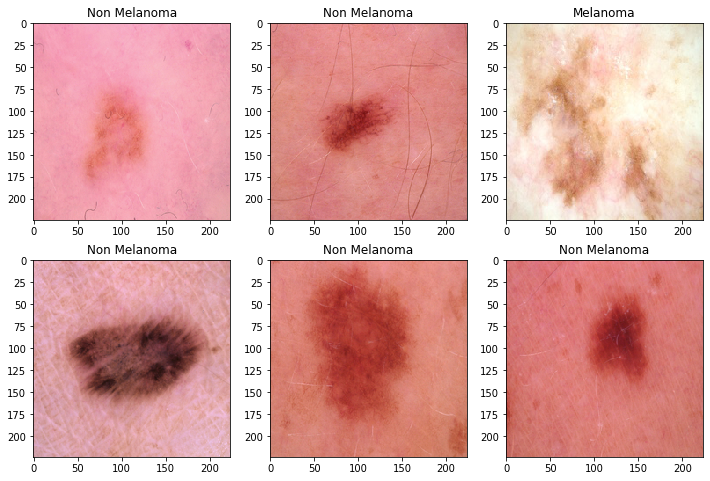

In [11]:
#plotting the images
fig=plt.figure(figsize=(12, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Non Melanoma')
    else:
        ax.title.set_text('Melanoma')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [0]:
#Reshaping the images so that it will be scaled
x_train = x_train/255.
x_test = x_test/255.

In [16]:
#using the mobilenet v2 from tensorflow hub as the model
import tensorflow_hub as hub
image_size=224

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

temp_model = hub.KerasLayer(URL, input_shape=(image_size, image_size, 3))
temp_model.trainable=True

model = tensorflow.keras.Sequential([
        temp_model,
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Dense(128, activation='relu'),
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Dense(128, activation='relu'),
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
#Comiling the model using adam optimizer and loss as binary crossentropy since it is binary classification
optimizer = Adam(lr=1e-5)
model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])

In [18]:
#training the model for 100 epochs
epochs = 100
batch_size = 64
history = model.fit(x_train, y_train, validation_split=0.25,
                    epochs= epochs, batch_size= batch_size)

Epoch 1/100
31/31 [==============================] - 11s 369ms/step - loss: 0.9178 - accuracy: 0.4734 - val_loss: 0.8411 - val_accuracy: 0.4273
Epoch 2/100
31/31 [==============================] - 10s 337ms/step - loss: 0.7959 - accuracy: 0.5357 - val_loss: 0.7551 - val_accuracy: 0.5939
Epoch 3/100
31/31 [==============================] - 10s 336ms/step - loss: 0.7409 - accuracy: 0.6141 - val_loss: 0.7018 - val_accuracy: 0.6939
Epoch 4/100
31/31 [==============================] - 10s 335ms/step - loss: 0.6905 - accuracy: 0.6702 - val_loss: 0.6560 - val_accuracy: 0.7212
Epoch 5/100
31/31 [==============================] - 10s 337ms/step - loss: 0.6401 - accuracy: 0.7344 - val_loss: 0.6158 - val_accuracy: 0.7561
Epoch 6/100
31/31 [==============================] - 10s 335ms/step - loss: 0.6063 - accuracy: 0.7542 - val_loss: 0.5771 - val_accuracy: 0.7697
Epoch 7/100
31/31 [==============================] - 10s 333ms/step - loss: 0.5767 - accuracy: 0.7663 - val_loss: 0.5433 - val_accuracy:

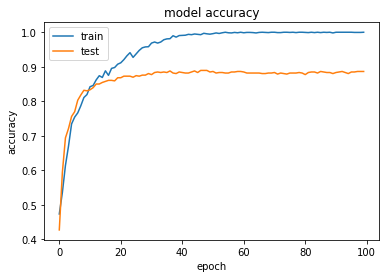

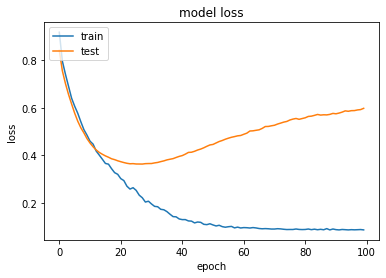

In [23]:
#plotting the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# pltting loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
#calculating the model prediction score
y_pred = model.predict_classes(x_test)
print(accuracy_score(y_test,y_pred))

0.8787878787878788


In [27]:
#Evaluating the model
test_accu = model.evaluate(x_test,y_test)
print(test_accu[1]*100)

21/21 [==============================] - 1s 29ms/step - loss: 0.6800 - accuracy: 0.8788
87.87878751754761


In [26]:
#displaying the confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np

classes=["not melanom","melanoma"]
classif=metrics.classification_report(y_test,y_pred,target_names=classes)
print(classif)

              precision    recall  f1-score   support

 not melanom       0.89      0.88      0.89       360
    melanoma       0.86      0.87      0.87       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660



In [36]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict_classes(images)
  if classes == 0:
    print("Non Melanoma",classes)
  else:
    print("Melanoma",classes)

Saving 44.jpg to 44 (1).jpg
Non Melanoma [[0]]


In [0]:
# Saving the  trained model 
saved1_keras_model_filepath = './modelown88%.h5'
model.save(saved1_keras_model_filepath)

In [0]:
#Loading the saved model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath
                                                  ,custom_objects={'KerasLayer':hub.KerasLayer})
reloaded_keras_model.summary()